In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
from google.colab.patches import cv2_imshow
from natsort import natsorted
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
import scipy.signal
from scipy.signal import find_peaks
import sys
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, AveragePooling3D, GlobalAveragePooling3D, Flatten, Dense, BatchNormalization, ReLU
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from scipy.signal import find_peaks
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K

In [ ]:
video = cv2.VideoCapture('/content/drive/MyDrive/UBFC_DATASET/DATASET_2/subject13/vid.avi')

fps = video.get(cv2.CAP_PROP_FPS)

print('FPS:', fps)

video.release()

FPS: 29.7903


In [ ]:
npz_file_path = '/content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject1.npz'

data = np.load(npz_file_path)
print(data['video'].shape)
print(data['wave'].shape)
print(data['hr'].shape)

(1547, 64, 64, 3)
(1547,)
(1547,)


Heart Rate (BPM): [81.24627273 89.3709     47.03731579 52.57111765 89.3709     33.72486792
 47.03731579 52.57111765 52.57111765 37.237875   66.20066667 47.03731579
 55.8568125  89.3709     57.65864516 52.57111765 61.63510345 89.3709
 55.8568125  54.16418182 54.16418182 39.7204     54.16418182 51.06908571
 34.37342308 36.47791837 57.65864516 57.65864516 37.237875   35.74836
 49.6505     59.5806     51.06908571 59.5806     59.5806     57.65864516
 33.72486792 52.57111765 54.16418182 55.8568125  55.8568125  59.5806
 52.57111765 35.74836   ]
Mean HR:  54.725633471199444
Real Mean HR:  106.70456819650937


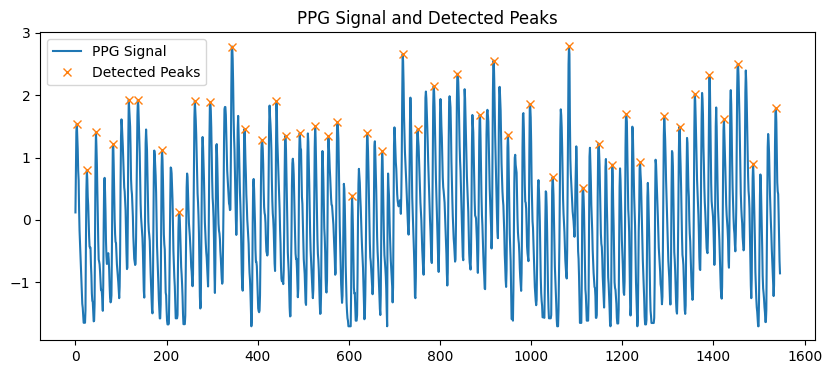

In [ ]:
ppg_signal = data['wave']

# 피크 검출
peaks, _ = find_peaks(ppg_signal, distance=20)  # 'distance'는 최소 피크 간격을 의미합니다. 실제 데이터에 맞게 조정하세요.

# 피크 사이의 시간 간격 계산 (샘플)
# 여기서는 샘플레이트가 1Hz라고 가정합니다. 실제 샘플레이트를 사용하세요.
sample_rate = fps  # Hz
peak_intervals = np.diff(peaks) / sample_rate

# 심박수 계산
heart_rate = 60 / peak_intervals  # 분당 박동수로 변환

print("Heart Rate (BPM):", heart_rate)

print('Mean HR: ', np.mean(heart_rate))
print('Real Mean HR: ', np.mean(data['hr']))
# 시각화
plt.figure(figsize=(10, 4))
plt.plot(ppg_signal, label='PPG Signal')
plt.plot(peaks, ppg_signal[peaks], "x", label='Detected Peaks')
plt.title("PPG Signal and Detected Peaks")
plt.legend()
plt.show()

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/everglow/ubfc-rppg/metadata_hr_csv_path.csv')
df

,id,path
0,1,/content/drive/MyDrive/everglow/ubfc-rppg/HR-n...
1,3,/content/drive/MyDrive/everglow/ubfc-rppg/HR-n...
2,4,/content/drive/MyDrive/everglow/ubfc-rppg/HR-n...
3,5,/content/drive/MyDrive/everglow/ubfc-rppg/HR-n...
4,8,/content/drive/MyDrive/everglow/ubfc-rppg/HR-n...
5,9,/content/drive/MyDrive/everglow/ubfc-rppg/HR-n...
6,10,/content/drive/MyDrive/everglow/ubfc-rppg/HR-n...
7,11,/content/drive/MyDrive/everglow/ubfc-rppg/HR-n...
8,12,/content/drive/MyDrive/everglow/ubfc-rppg/HR-n...
9,13,/content/drive/MyDrive/everglow/ubfc-rppg/HR-n...


In [ ]:
frame_counts = []
for _, row in df.iterrows():
    with np.load(row['path'], allow_pickle=True) as data:
        video = data['video']
        frame_counts.append(video.shape[0])  # 비디오 시퀀스의 길이 (프레임 수) 추가

# 최소 프레임 수 찾기
min_frames = min(frame_counts)
print(f"Minimum number of frames in the dataset: {min_frames}")

Minimum number of frames in the dataset: 1368


In [ ]:
def calculate_hr(wave):
  ppg_signal = wave

  # 피크 검출
  peaks, _ = find_peaks(ppg_signal, distance=20)  # 'distance'는 최소 피크 간격을 의미합니다. 실제 데이터에 맞게 조정하세요.

  # 피크 사이의 시간 간격 계산 (샘플)
  # 여기서는 샘플레이트가 1Hz라고 가정합니다. 실제 샘플레이트를 사용하세요.
  sample_rate = fps  # Hz
  peak_intervals = np.diff(peaks) / sample_rate

  # 심박수 계산
  heart_rate = 60 / peak_intervals  # 분당 박동수로 변환

  return np.mean(heart_rate)

In [ ]:
def load_dataset(df):
    video_data = []
    ppg_data = []
    hr_data = []

    for _, row in df.iterrows():
        with np.load(row['path']) as data:
            video = data['video']
            wave = data['wave']
            hr = data['hr']
            if video.shape[0] > min_frames:
                video = video[:min_frames]
                wave = wave[:min_frames]
                hr = hr[:min_frames]

            video_data.append(video)
            ppg_data.append(wave)
            hr_data.append(hr)
            ## 모델 입력을 HR로 할 결루
            # heart_rate = calculate_hr(wave)
            # ppg_data.append(heart_rate)

    return np.array(video_data), np.array(hr_data)

video_data, ppg_data = load_dataset(df)

In [ ]:
# VGG 스타일의 3D CNN 모델을 생성하는 함수
def VGG_3D(input_shape, num_classes):
    model = Sequential()

    # 첫 번째 블록
    model.add(Conv3D(64, (3, 3, 3), padding='same', activation='relu',
                     input_shape=input_shape, kernel_regularizer=l2(0.001)))
    model.add(Conv3D(64, (3, 3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.001)))
    model.add(AveragePooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2)))

    # 두 번째 블록
    model.add(Conv3D(128, (3, 3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Conv3D(128, (3, 3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.001)))
    model.add(AveragePooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2)))

    # 세 번째 블록
    model.add(Conv3D(256, (3, 3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Conv3D(256, (3, 3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Conv3D(256, (3, 3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.001)))
    model.add(AveragePooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2)))

    # 네 번째 블록
    model.add(Conv3D(512, (3, 3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Conv3D(512, (3, 3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Conv3D(512, (3, 3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.001)))
    model.add(AveragePooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2)))

    # 다섯 번째 블록
    model.add(Conv3D(512, (3, 3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Conv3D(512, (3, 3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Conv3D(512, (3, 3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.001)))
    model.add(AveragePooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2)))

    # 분류를 위한 완전 연결 레이어
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(2048, activation='relu'))
    model.add(Dense(min_frames, activation='linear'))  # 회귀 문제이므로 'linear' 활성화 함수 사용

    return model

# 모델 생성
input_shape = (min_frames, 64, 64, 3)  # 입력 형태 정의 (프레임 수, 높이, 너비, 채널)
num_classes = 1  # PPG 신호의 경우 연속적인

In [ ]:
def build_mobilenet_3d_regression(input_shape=(1368, 64, 64, 3), num_classes=min_frames):
    model = Sequential()

    model.add(Conv3D(filters=32, kernel_size=3, strides=(2, 2, 2), padding="same",
                     activation=None, use_bias=False, input_shape=input_shape,
                     kernel_regularizer=l2(0.0001)))
    model.add(BatchNormalization())
    model.add(ReLU())

    model.add(Conv3D(filters=64, kernel_size=3, padding="same",
                     activation=None, use_bias=False,
                     kernel_regularizer=l2(0.0001)))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPooling3D(pool_size=(3, 3, 3), strides=(2, 2, 2), padding="same"))

    # Add more layers as needed...

    # Global Average Pooling followed by a Dense layer for regression
    model.add(GlobalAveragePooling3D())
    model.add(Dense(units=num_classes, activation='linear'))  # For regression

    return model

In [ ]:
# 데이터를 학습, 검증, 테스트 세트로 분할
video_train, video_test, ppg_train, ppg_test = train_test_split(video_data, ppg_data, test_size=0.2, random_state=42)
video_train, video_val, ppg_train, ppg_val = train_test_split(video_train, ppg_train, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2

print(f"video_train shape: {video_train.shape}")
print(f"video_val shape: {video_val.shape}")
print(f"video_test shape: {video_test.shape}")
print(f"ppg_train shape: {ppg_train.shape}")
print(f"ppg_val shape: {ppg_val.shape}")
print(f"ppg_test shape: {ppg_test.shape}")

video_train shape: (24, 1368, 64, 64, 3)
video_val shape: (9, 1368, 64, 64, 3)
video_test shape: (9, 1368, 64, 64, 3)
ppg_train shape: (24, 1368)
ppg_val shape: (9, 1368)
ppg_test shape: (9, 1368)


In [ ]:

# RMSE 손실 함수
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

model = build_mobilenet_3d_regression(input_shape=(min_frames, 64, 64, 3), num_classes=min_frames)

optimizer = Adam(learning_rate=0.01)

model.compile(optimizer=Adam(), loss=mean_squared_error)

# 모델 학습
history = model.fit(video_train, ppg_train, validation_data=(video_val, ppg_val), epochs=10000, batch_size=8)



Streaming output truncated to the last 5000 lines.
Epoch 7501/10000
3/3 [==============================] - 2s 553ms/step - loss: 22.7296 - val_loss: 754.0037
Epoch 7502/10000
3/3 [==============================] - 2s 568ms/step - loss: 15.8147 - val_loss: 704.6899
Epoch 7503/10000
3/3 [==============================] - 2s 557ms/step - loss: 11.7279 - val_loss: 932.5295
Epoch 7504/10000
3/3 [==============================] - 2s 548ms/step - loss: 16.0373 - val_loss: 983.5364
Epoch 7505/10000
3/3 [==============================] - 2s 548ms/step - loss: 14.6246 - val_loss: 711.4722
Epoch 7506/10000
3/3 [==============================] - 2s 549ms/step - loss: 11.1808 - val_loss: 908.7192
Epoch 7507/10000
3/3 [==============================] - 2s 550ms/step - loss: 15.1076 - val_loss: 712.7761
Epoch 7508/10000
3/3 [==============================] - 2s 550ms/step - loss: 18.7307 - val_loss: 670.5682
Epoch 7509/10000
3/3 [==============================] - 2s 558ms/step - loss: 16.2442 - val_l

In [ ]:
# 테스트 데이터로 성능 평가
test_loss = model.evaluate(video_test, ppg_test, batch_size=1)
print(f'Test RMSE: {test_loss}')

predicted_ppg = model.predict(video_test, batch_size=1)

9/9 [==============================] - 0s 18ms/step - loss: 707.0526
Test RMSE: 707.0526123046875
9/9 [==============================] - 0s 17ms/step


In [ ]:
# 예측 결과 출력
print(predicted_ppg[0])
print(predicted_ppg[1])


[113.92638  113.76331  113.8707   ...  90.22212   90.25548   90.198044]
[ 94.2722    94.16876   94.15646  ... 112.25948  112.34568  112.248955]


[120. 120. 120. ... 116. 116. 116.]
[113.92638  113.76331  113.8707   ...  90.22212   90.25548   90.198044]
Actual mean HR:  118.58897660818714
Predicted mean HR:  125.086945


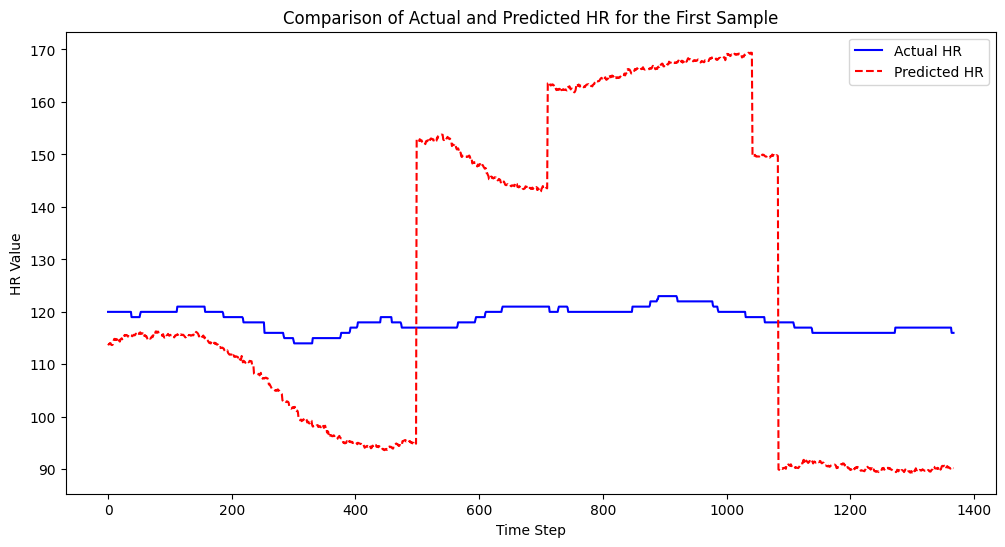

In [ ]:
print(ppg_test[0])
print(predicted_ppg[0])

print('Actual mean HR: ', np.mean(ppg_test[0]))
print('Predicted mean HR: ', np.mean(predicted_ppg[0]))

plt.figure(figsize=(12, 6))
plt.plot(ppg_test[0], label='Actual HR', color='blue')
plt.plot(predicted_ppg[0], label='Predicted HR', color='red', linestyle='--')
plt.title('Comparison of Actual and Predicted HR for the First Sample')
plt.xlabel('Time Step')
plt.ylabel('HR Value')
plt.legend()
plt.show()


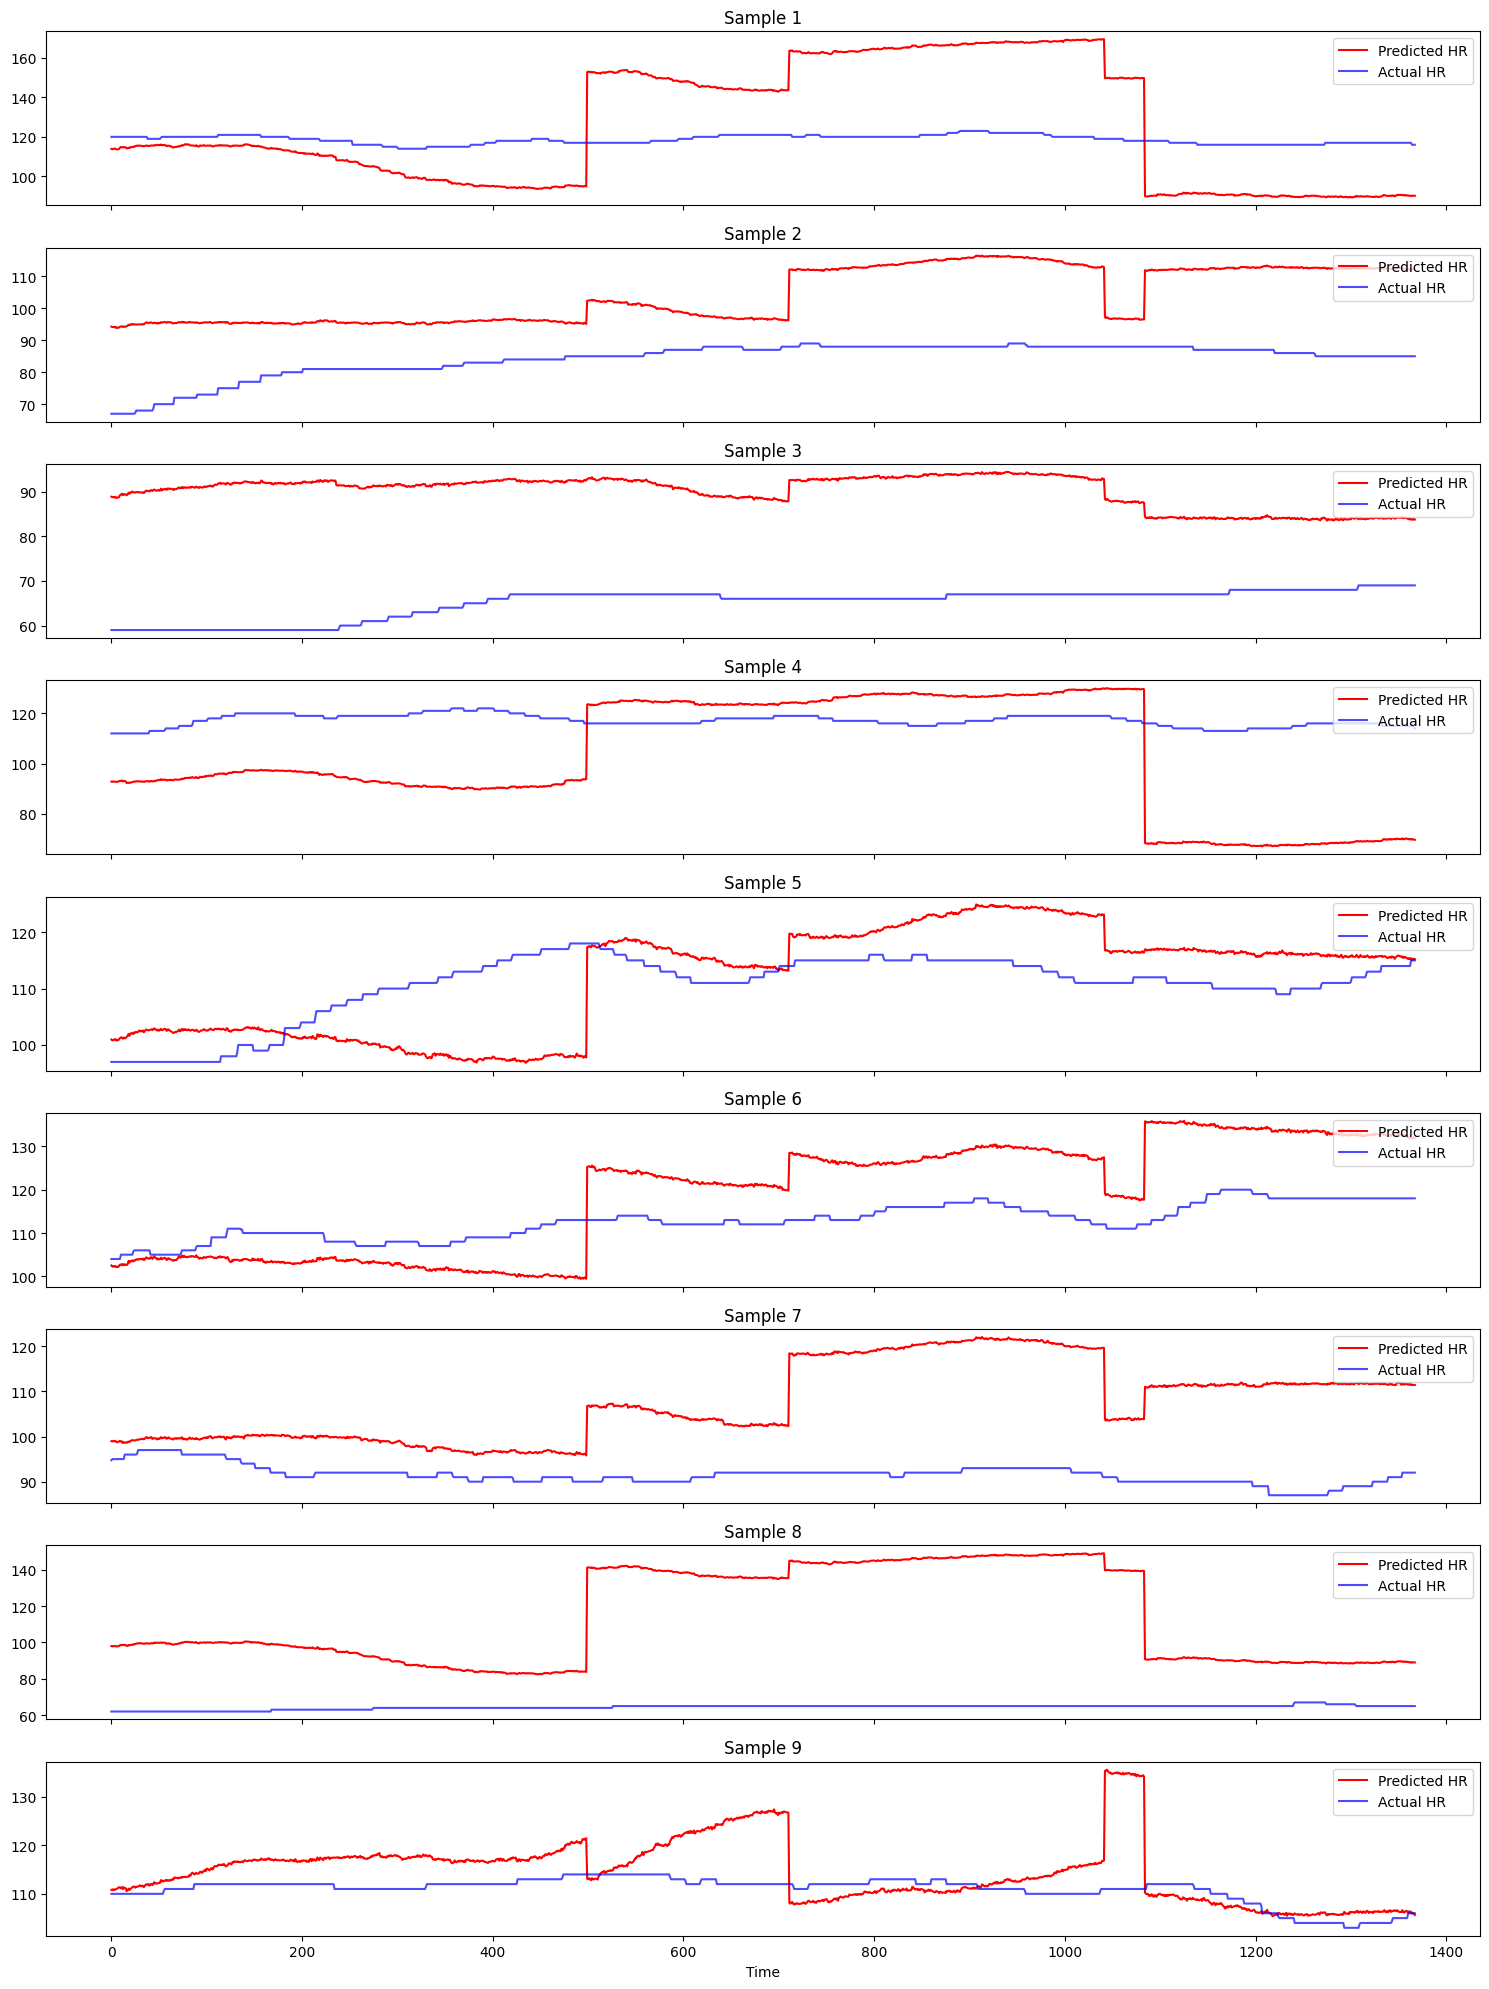

In [ ]:
fig, axs = plt.subplots(9, 1, figsize=(15, 20), sharex=True)

for i in range(9):
    axs[i].plot(predicted_ppg[i], label='Predicted HR', color='red')
    axs[i].plot(ppg_test[i], label='Actual HR', color='blue', alpha=0.7)
    axs[i].set_title(f'Sample {i+1}')
    axs[i].legend(loc='upper right')  # 라벨 위치를 오른쪽 상단으로 고정

plt.xlabel('Time')
plt.tight_layout()  # 레이아웃 조정으로 서브플롯 간 겹침 방지
plt.show()